In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['resnet18', 'aerial-cactus-identification', 'resnet34']


In [2]:
df = pd.DataFrame.from_csv('../input/aerial-cactus-identification/train.csv', index_col=None)
df.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  """Entry point for launching an IPython kernel.


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [3]:
from os import makedirs
makedirs('/tmp/.torch/models/')

In [4]:
!cp ../input/resnet18/resnet18.pth /tmp/.torch/models/resnet18-5c106cde.pth

In [7]:
from fastai.vision import *
test_data = ImageList.from_folder('../input/aerial-cactus-identification/test/test')
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.2, p_affine=0.75, p_lighting=0.75)
data = (ImageList.from_df(df, path='../input/aerial-cactus-identification/train/train')
        .split_by_rand_pct(0.1)
        .label_from_df()
        .add_test(test_data)
        .transform(trfm, size=128)
        .databunch(path='.', bs=64, device= torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

In [8]:
import pathlib
data.path = pathlib.Path('.')
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


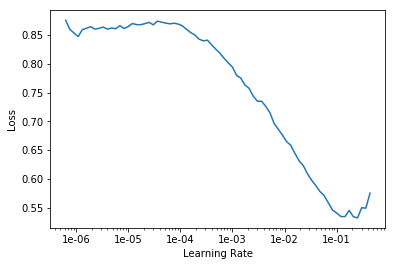

In [9]:
learn.recorder.plot()

In [10]:
learn.fit_one_cycle(5, 1e-02)

epoch,train_loss,valid_loss,accuracy,time
0,0.061112,0.064042,0.975429,00:46
1,0.054193,0.014698,0.994857,00:44
2,0.025294,0.003281,0.998857,00:44
3,0.016662,0.002997,0.999429,00:44
4,0.012187,0.002681,0.998857,00:45


In [ ]:
preds = learn.get_preds(ds_type=DatasetType.Test)

preds = [x[1] for x in preds[0].tolist()]
preds

In [ ]:
pred_df = []
for item in zip(data.test_ds.items, preds):
    pred_df.append([item[0].stem + '.jpg', item[1]])

In [ ]:
pred_df = pd.DataFrame(pred_df, columns=['id', 'has_cactus'])

In [ ]:
pred_df.to_csv('submission.csv', index=False)